In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# import data
polyps = pd.read_csv('polyps.csv')



In [3]:
# set rng seed
torch.manual_seed(111)

In [4]:
# prepping training data
# pairs (x₁, x₂) so that x₂ consists of the value of the sine of x₁ for x₁ in the interval from 0 to 2π
# need a tensor of labels

# train data should be demographic info for x1 and percentage difference for x2
# labels is the treatment (test/control)

demo = polyps['demo']
rel =  polyps['rel_3']
train_data = [(demo[i], rel[i]) for i in range(len(demo))]


labels = polyps['treatment']

labels = tf.constant(labels, dtype=tf.float32)
demo = tf.constant(demo, dtype=tf.float32)
rel = tf.constant(rel, dtype=tf.float32)


# need to convert to torch tensors
train_data = pd.DataFrame(train_data)
train_data = train_data.astype(float)
train_data = tf.constant(train_data, dtype=tf.float32)


labels = torch.as_tensor(labels.numpy())
train_data = torch.as_tensor(train_data.numpy())

print(train_data)
print(train_data.shape)

tensor([[ 1.0000e+21, -1.4286e-01],
        [ 1.0000e+21, -1.2987e-01],
        [ 1.0001e+20, -4.2857e-01],
        [ 1.0000e+21,  0.0000e+00],
        [ 1.0000e+20, -3.0435e-01],
        [ 1.0001e+21, -1.1429e-01],
        [ 1.0000e+21, -4.5455e-01],
        [ 1.0000e+20,  6.6667e-01],
        [ 1.0000e+20,  0.0000e+00],
        [ 1.0001e+20,  9.1195e-02],
        [ 1.0001e+20, -1.1250e-01],
        [ 1.0000e+21, -8.7500e-01],
        [ 1.0000e+20, -2.0000e-01],
        [ 1.0000e+20,  8.1818e-01],
        [ 1.0000e+20,  8.3333e-02],
        [ 1.0000e+20, -2.0588e-01],
        [ 1.0000e+21, -1.6667e-01],
        [ 1.0010e+20, -3.7500e-01],
        [ 1.0000e+20,  0.0000e+00],
        [ 1.0000e+21, -4.0000e-01],
        [ 1.0000e+21, -7.5000e-01],
        [ 1.0000e+20, -3.3333e-01]])
torch.Size([22, 2])


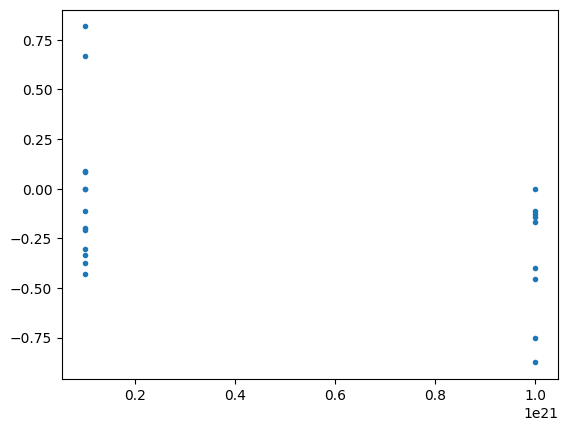

In [5]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [6]:

train_set = [
    (train_data[i], labels[i]) for i in range(len(train_data))
]

print(train_set)


[(tensor([ 1.0000e+21, -1.4286e-01]), tensor(1.)), (tensor([ 1.0000e+21, -1.2987e-01]), tensor(0.)), (tensor([ 1.0001e+20, -4.2857e-01]), tensor(1.)), (tensor([1.0000e+21, 0.0000e+00]), tensor(0.)), (tensor([ 1.0000e+20, -3.0435e-01]), tensor(1.)), (tensor([ 1.0001e+21, -1.1429e-01]), tensor(0.)), (tensor([ 1.0000e+21, -4.5455e-01]), tensor(1.)), (tensor([1.0000e+20, 6.6667e-01]), tensor(0.)), (tensor([1.0000e+20, 0.0000e+00]), tensor(0.)), (tensor([1.0001e+20, 9.1195e-02]), tensor(0.)), (tensor([ 1.0001e+20, -1.1250e-01]), tensor(1.)), (tensor([ 1.0000e+21, -8.7500e-01]), tensor(1.)), (tensor([ 1.0000e+20, -2.0000e-01]), tensor(0.)), (tensor([1.0000e+20, 8.1818e-01]), tensor(0.)), (tensor([1.0000e+20, 8.3333e-02]), tensor(0.)), (tensor([ 1.0000e+20, -2.0588e-01]), tensor(1.)), (tensor([ 1.0000e+21, -1.6667e-01]), tensor(0.)), (tensor([ 1.0010e+20, -3.7500e-01]), tensor(1.)), (tensor([1.0000e+20, 0.0000e+00]), tensor(0.)), (tensor([ 1.0000e+21, -4.0000e-01]), tensor(1.)), (tensor([ 1.0

In [7]:
# definting collate function, part of the train_loader command. This ends up not being used in this example, may be needed in a different case
def collate_fn(data):
    """
    data: is a list of tuples with (example, label, length)
          where 'example' is a tensor of arbitrary shape
          and label/length are scalars
    """
    
    examples, labels, lengths = zip(*data)
    max_len = max(lengths)
    n_ftrs = examples[0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = examples[i].size(0), examples[i].size(1)
        features[i] = torch.cat([examples[i], torch.zeros((max_len - j, k))])

    return features.float(), labels.long(), lengths.long()


# create data loader
# shuffles data from train set and returns batches of 2 samples to train
# batch size dependent on sample size

batch_size = 2

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, collate_fn = None, shuffle=True
)




In [8]:
# creates discriminator
# needs 2D input and gives 1D output
# recieve sample from real data, provide probability that sample belongs to real training data

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [9]:
discriminator = Discriminator()

In [10]:
# implement generator
# takes samples from latent space as input, gen data resembling data in training set as output
# 2D input, 2D output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [11]:
# training parameters

lr = 0.001
# learning rate
num_epochs = 30
# number of repetitions
loss_function = nn.BCELoss()
# loss function

In [12]:
# weight update rules, using ADAM

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:

# training loop

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        #real_samples_labels = real_samples_labels
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 25.341154098510742
Epoch: 0 Loss G.: 0.7067089080810547
Epoch: 10 Loss D.: 50.00004577636719
Epoch: 10 Loss G.: 8.69852352142334
Epoch: 20 Loss D.: 50.00001907348633
Epoch: 20 Loss G.: 11.326689720153809


In [14]:
# check gen samples

latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

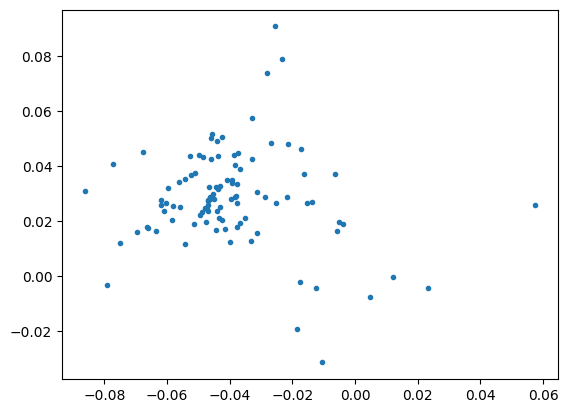

In [15]:
# check gen samples 

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")



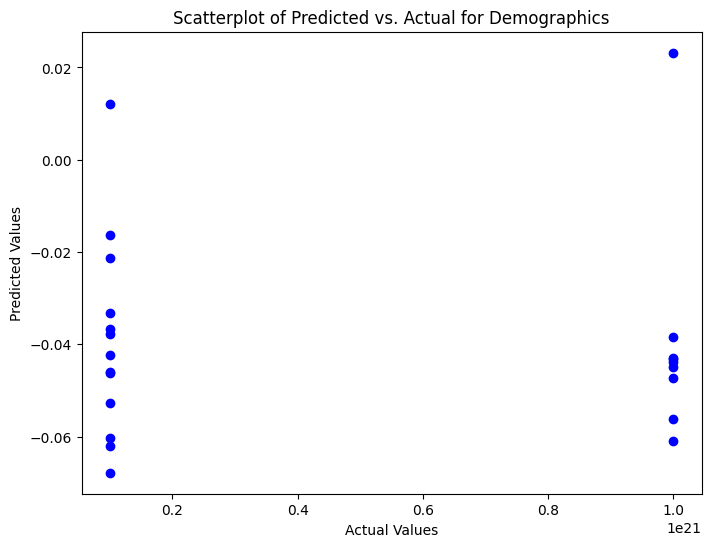

In [16]:
import matplotlib.pyplot as plt
generated_samples = pd.DataFrame(generated_samples)
train_data = pd.DataFrame(train_data)
generated_samples = generated_samples.iloc[0:22]
train_data_0 = train_data[0]
generated_samples_0 = generated_samples[0]


plt.figure(figsize=(8, 6))
plt.scatter(train_data_0, generated_samples_0, c='blue', marker='o')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatterplot of Predicted vs. Actual for Demographics')

#plt.savefig('.png')
plt.show()

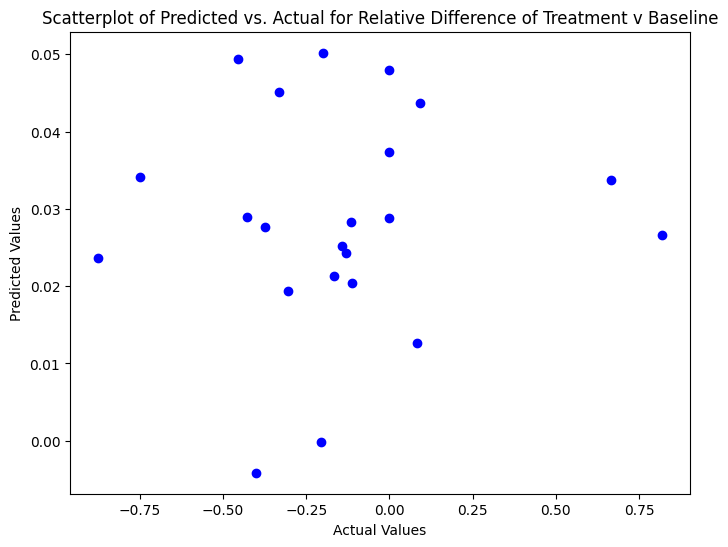

In [17]:
import matplotlib.pyplot as plt
generated_samples = pd.DataFrame(generated_samples)
train_data = pd.DataFrame(train_data)
generated_samples = generated_samples.iloc[0:22]
train_data_1 = train_data[1]
generated_samples_1 = generated_samples[1]


plt.figure(figsize=(8, 6))
plt.scatter(train_data_1, generated_samples_1, c='blue', marker='o')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatterplot of Predicted vs. Actual for Relative Difference of Treatment v Baseline')

#plt.savefig('.png')
plt.show()

In [18]:
#print(generated_samples)
 

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for demo
y_test = train_data_0
predictions = generated_samples_0


# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)


#Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, predictions)
print('Pearsons correlation: %.3f' % corr)

MAE: 4.6819408e+20
MSE: inf
RMSE: inf
R-squared: nan
Pearsons correlation: -0.003


C:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:927: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
C:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:929: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2
C:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:633: RuntimeWarning: invalid value encountered in divide
  numerator[valid_score] / denominator[valid_score]


In [20]:
# for rel 
y_test = train_data_1
predictions = generated_samples_1


# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)

#Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, predictions)
print('Pearsons correlation: %.3f' % corr)

MAE: 0.3201516
MSE: 0.16916955
RMSE: 0.41130227
R-squared: -0.23237634041818112
Pearsons correlation: 0.064
